In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pylab
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score, KFold
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
# import data

df = pd.read_csv("/Users/idaba/OneDrive/Desktop/BANA 650/650 Project/patient_df.csv")

In [3]:
# drop duplicates

df = df.drop_duplicates(subset='SUBJECT_ID', keep='first')

In [4]:
# see the shape

df.shape

(4555, 45)

In [5]:
# get column names

df.columns

Index(['Unnamed: 0', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD',
       'HOSPITAL_EXPIRE_FLAG', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'ADMISSION_TYPE', 'ETHNICITY', 'AGE_AT_ADMISSION', 'LOS',
       'LOS_ICU_MEAN', 'WEIGHT_MEAN', 'HEARTRATE_MEAN', 'SBP_MEAN', 'DBP_MEAN',
       'MAP_MEAN', 'RR_MEAN', 'TEMP_MEAN_C', 'TEMP_MIN_C', 'TEMP_MAX_C',
       'OXYGEN_SAT_MEAN', 'DIABETES', 'ANIONGAP_MAX_VAL', 'BUN_MAX_VAL',
       'CHLORIDE_MAX_VAL', 'CREATININE_MAX_VAL', 'HEMOGLOBIN_MAX_VAL',
       'INR_MAX_VAL', 'LACTATE_MAX_VAL', 'PLATELET_MAX_VAL',
       'POTASSIUM_MAX_VAL', 'SODIUM_MAX_VAL', 'ANIONGAP_MIN_VAL',
       'BUN_MIN_VAL', 'CHLORIDE_MIN_VAL', 'CREATININE_MIN_VAL',
       'HEMOGLOBIN_MIN_VAL', 'INR_MIN_VAL', 'LACTATE_MIN_VAL',
       'PLATELET_MIN_VAL', 'POTASSIUM_MIN_VAL', 'SODIUM_MIN_VAL'],
      dtype='object')

In [6]:
# adjust data type
df['DOD'] = pd.to_datetime(df['DOD'])
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])

In [7]:
# define 30-days mortality column and drop net income

df['DIFF_DAYS'] = (df['DOD'] - df['ADMITTIME']).dt.days
df['MORTALITY'] = df['DIFF_DAYS'].apply(lambda x: 0 if x>30 else 1)

In [8]:
# inspect the data

df['MORTALITY'].value_counts()

MORTALITY
1    3281
0    1274
Name: count, dtype: int64

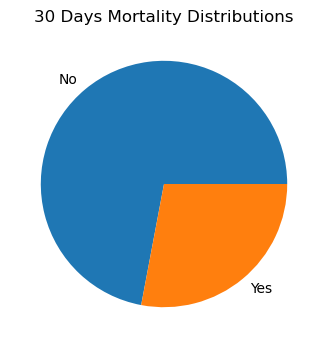

In [9]:
# mortality

mortality_counts = df['MORTALITY'].value_counts()

plt.figure(figsize=(4,4))
plt.pie(mortality_counts, labels=['No','Yes'])
plt.title('30 Days Mortality Distributions')
plt.show()

In [10]:
# drop irrelevant and redundant variables

df = df.drop(['Unnamed: 0', 'SUBJECT_ID', 'DOB', 'DOD','HOSPITAL_EXPIRE_FLAG', 'HADM_ID', 'ADMITTIME', 'DIFF_DAYS', 'DISCHTIME','TEMP_MEAN_C', 'CHLORIDE_MAX_VAL', 'CREATININE_MAX_VAL', 'LACTATE_MAX_VAL', 'PLATELET_MAX_VAL','POTASSIUM_MAX_VAL'], axis =1)

In [11]:
# see the data type for each field

df.dtypes

GENDER                 object
ADMISSION_TYPE         object
ETHNICITY              object
AGE_AT_ADMISSION        int64
LOS                     int64
LOS_ICU_MEAN          float64
WEIGHT_MEAN           float64
HEARTRATE_MEAN        float64
SBP_MEAN              float64
DBP_MEAN              float64
MAP_MEAN              float64
RR_MEAN               float64
TEMP_MIN_C            float64
TEMP_MAX_C            float64
OXYGEN_SAT_MEAN       float64
DIABETES              float64
ANIONGAP_MAX_VAL      float64
BUN_MAX_VAL           float64
HEMOGLOBIN_MAX_VAL    float64
INR_MAX_VAL           float64
SODIUM_MAX_VAL        float64
ANIONGAP_MIN_VAL      float64
BUN_MIN_VAL           float64
CHLORIDE_MIN_VAL      float64
CREATININE_MIN_VAL    float64
HEMOGLOBIN_MIN_VAL    float64
INR_MIN_VAL           float64
LACTATE_MIN_VAL       float64
PLATELET_MIN_VAL      float64
POTASSIUM_MIN_VAL     float64
SODIUM_MIN_VAL        float64
MORTALITY               int64
dtype: object

In [12]:
# gruoo ethnicity (Code form Joshua Cabal)

def consolidate_ethnicity(ethnicity):
    ethnicity = ethnicity.upper()  # Convert to uppercase for consistency
    
    # Grouping logic
    if 'WHITE' in ethnicity:
        return 'WHITE'
    elif 'BLACK' in ethnicity or 'AFRICAN AMERICAN' in ethnicity:
        return 'BLACK OR AFRICAN AMERICAN'
    elif 'ASIAN' in ethnicity:
        return 'ASIAN'
    elif 'HISPANIC' in ethnicity or 'LATINO' in ethnicity:
        return 'HISPANIC OR LATINO'
    elif 'AMERICAN INDIAN' in ethnicity or 'ALASKA NATIVE' in ethnicity:
        return 'AMERICAN INDIAN OR ALASKA NATIVE'
    elif 'NATIVE HAWAIIAN' in ethnicity or 'PACIFIC ISLANDER' in ethnicity:
        return 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'
    elif 'MIDDLE EASTERN' in ethnicity:
        return 'MIDDLE EASTERN'
    elif ('UNKNOWN' in ethnicity or 'NOT SPECIFIED' in ethnicity or
          'DECLINED TO ANSWER' in ethnicity or 'UNABLE TO OBTAIN' in ethnicity):
        return 'UNKNOWN/NOT SPECIFIED/DECLINED'
    else:
        return 'OTHER'
    


df['ETHNICITY'] = df['ETHNICITY'].apply(consolidate_ethnicity)

print(df['ETHNICITY'].value_counts())

ETHNICITY
WHITE                                        3360
BLACK OR AFRICAN AMERICAN                     436
UNKNOWN/NOT SPECIFIED/DECLINED                340
ASIAN                                         148
HISPANIC OR LATINO                            144
OTHER                                         117
AMERICAN INDIAN OR ALASKA NATIVE                4
MIDDLE EASTERN                                  4
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER       2
Name: count, dtype: int64


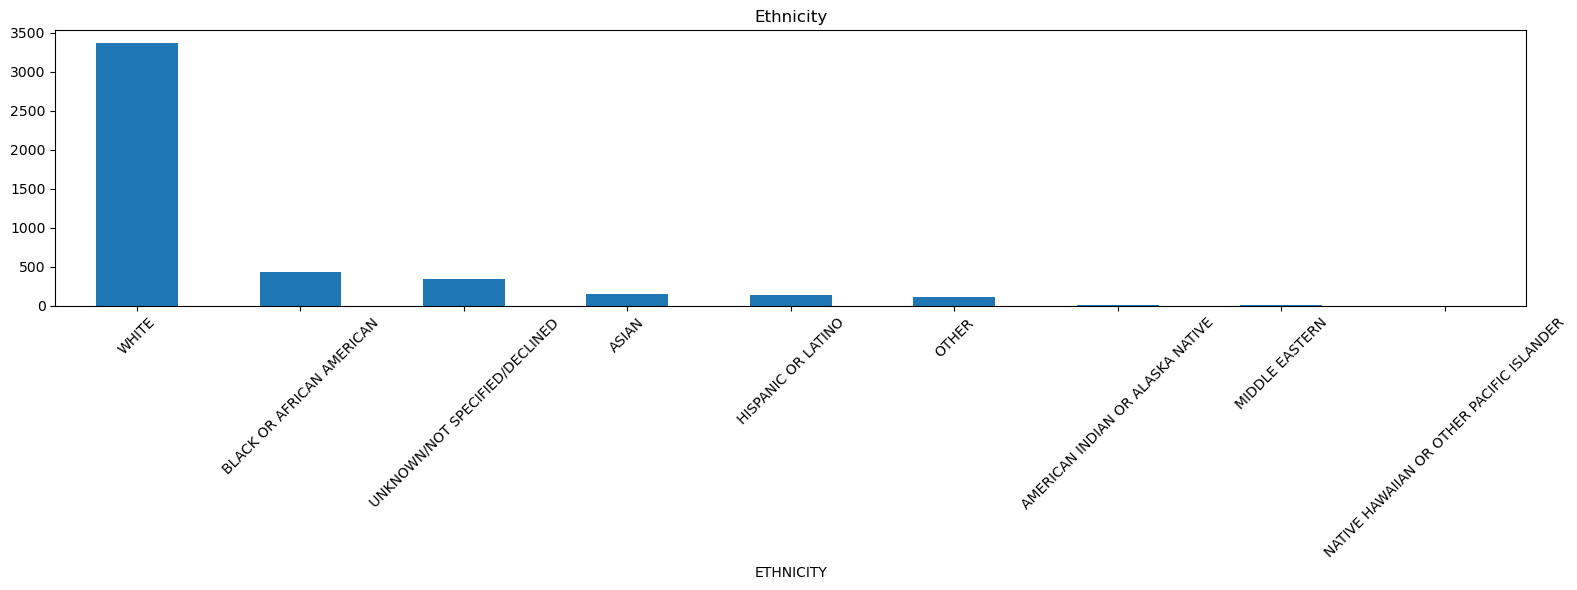

In [13]:
# inspect the data using visualization

plt.figure(figsize=(16, 6)) 
my_bins = df['ETHNICITY'].value_counts()
my_bins.plot(kind='bar') 
plt.xticks(rotation=45) 
plt.title('Ethnicity') 
plt.tight_layout() 
plt.show()

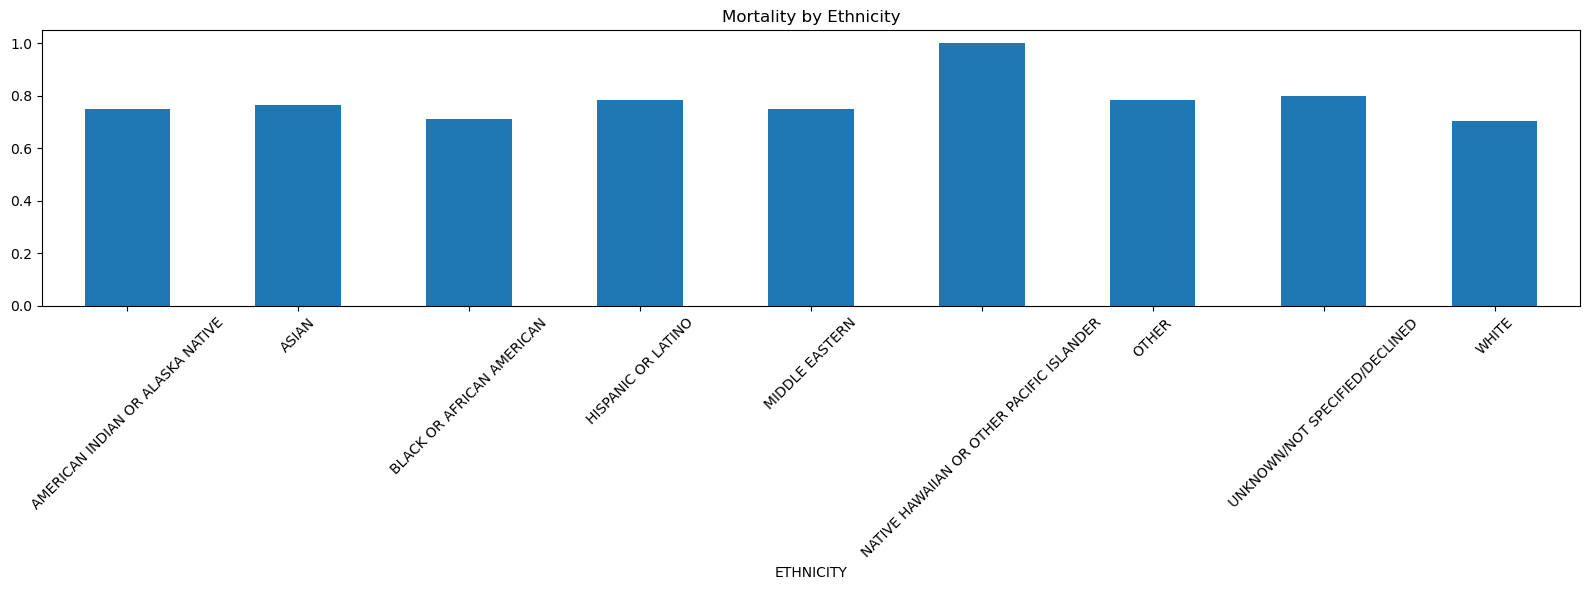

In [14]:
# inspect the data using visualization

ethnicity = df.groupby('ETHNICITY')['MORTALITY'].mean()
plt.figure(figsize=(16, 6))
ethnicity.plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Mortality by Ethnicity')
plt.tight_layout()
plt.show()

In [15]:
# see if there is a signingficant difference between the groups

def chiStat(df, targetCol, varCol):
    table = pd.crosstab(df[targetCol], df[varCol])
    chi2_stat, p_val, dof, expected = chi2_contingency(table)

    print('chi-squared statistic:', chi2_stat)
    print('P-value:', p_val)
    print('Degrees of freedom:', dof)
    print('Expected frequencies:')
    print(expected)

chiStat(df, 'MORTALITY', 'ETHNICITY')

chi-squared statistic: 21.940778878649233
P-value: 0.005026763602206442
Degrees of freedom: 8
Expected frequencies:
[[1.11877058e+00 4.13945115e+01 1.21945993e+02 4.02757409e+01
  1.11877058e+00 5.59385291e-01 3.27240395e+01 9.50954995e+01
  9.39767289e+02]
 [2.88122942e+00 1.06605488e+02 3.14054007e+02 1.03724259e+02
  2.88122942e+00 1.44061471e+00 8.42759605e+01 2.44904501e+02
  2.42023271e+03]]


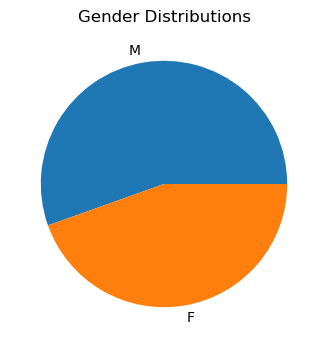

In [16]:
# inspect the data using visualization

gender_counts = df['GENDER'].value_counts()

plt.figure(figsize=(4,4))
plt.pie(gender_counts, labels=['M','F'])
plt.title('Gender Distributions')
plt.show()

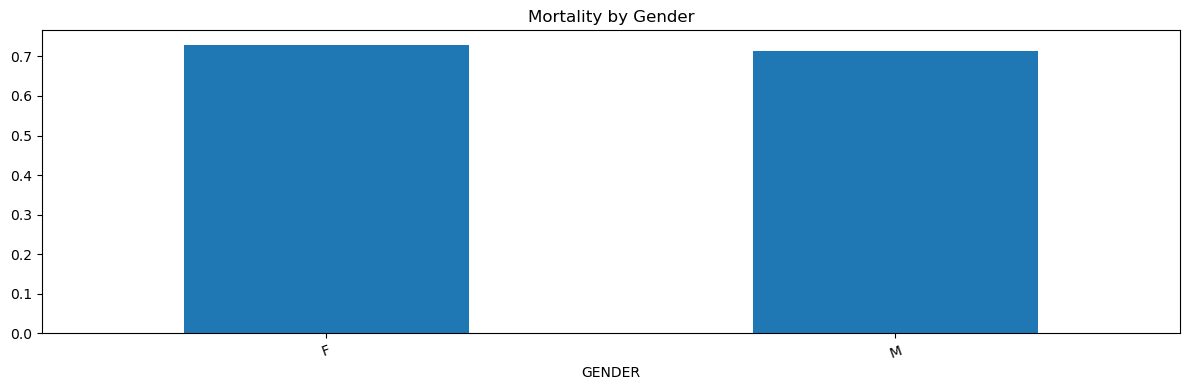

In [17]:
# inspect the data using visualization

gender = df.groupby('GENDER')['MORTALITY'].mean()
plt.figure(figsize=(12, 4))
gender.plot(kind='bar')
plt.xticks(rotation=20)
plt.title('Mortality by Gender')
plt.tight_layout()
plt.show()

In [18]:
# see if there is a signingficant difference between the groups

def chiStat(df, targetCol, varCol):
    table = pd.crosstab(df[targetCol], df[varCol])
    chi2_stat, p_val, dof, expected = chi2_contingency(table)

    print('chi-squared statistic:', chi2_stat)
    print('P-value:', p_val)
    print('Degrees of freedom:', dof)
    print('Expected frequencies:')
    print(expected)

chiStat(df, 'MORTALITY', 'GENDER')

chi-squared statistic: 1.4287106646326184
P-value: 0.23197497397598826
Degrees of freedom: 1
Expected frequencies:
[[ 567.49637761  706.50362239]
 [1461.50362239 1819.49637761]]


In [19]:
# get column names

df.columns

Index(['GENDER', 'ADMISSION_TYPE', 'ETHNICITY', 'AGE_AT_ADMISSION', 'LOS',
       'LOS_ICU_MEAN', 'WEIGHT_MEAN', 'HEARTRATE_MEAN', 'SBP_MEAN', 'DBP_MEAN',
       'MAP_MEAN', 'RR_MEAN', 'TEMP_MIN_C', 'TEMP_MAX_C', 'OXYGEN_SAT_MEAN',
       'DIABETES', 'ANIONGAP_MAX_VAL', 'BUN_MAX_VAL', 'HEMOGLOBIN_MAX_VAL',
       'INR_MAX_VAL', 'SODIUM_MAX_VAL', 'ANIONGAP_MIN_VAL', 'BUN_MIN_VAL',
       'CHLORIDE_MIN_VAL', 'CREATININE_MIN_VAL', 'HEMOGLOBIN_MIN_VAL',
       'INR_MIN_VAL', 'LACTATE_MIN_VAL', 'PLATELET_MIN_VAL',
       'POTASSIUM_MIN_VAL', 'SODIUM_MIN_VAL', 'MORTALITY'],
      dtype='object')

In [20]:
# see statistics 

df.describe().round()

,AGE_AT_ADMISSION,LOS,LOS_ICU_MEAN,WEIGHT_MEAN,HEARTRATE_MEAN,SBP_MEAN,DBP_MEAN,MAP_MEAN,RR_MEAN,TEMP_MIN_C,...,BUN_MIN_VAL,CHLORIDE_MIN_VAL,CREATININE_MIN_VAL,HEMOGLOBIN_MIN_VAL,INR_MIN_VAL,LACTATE_MIN_VAL,PLATELET_MIN_VAL,POTASSIUM_MIN_VAL,SODIUM_MIN_VAL,MORTALITY
count,4555.0,4555.0,4554.0,4323.0,4550.0,4551.0,4551.0,4551.0,4551.0,4543.0,...,4553.0,4552.0,4553.0,4553.0,4520.0,4466.0,4553.0,4553.0,4552.0,4555.0
mean,67.0,14.0,7.0,83.0,89.0,114.0,59.0,75.0,20.0,34.0,...,16.0,96.0,1.0,8.0,1.0,1.0,130.0,3.0,132.0,1.0
std,16.0,17.0,8.0,26.0,14.0,29.0,13.0,10.0,4.0,7.0,...,15.0,7.0,1.0,2.0,0.0,1.0,94.0,1.0,6.0,0.0
min,18.0,-1.0,0.0,24.0,50.0,35.0,17.0,38.0,7.0,-73.0,...,1.0,17.0,0.0,2.0,0.0,0.0,5.0,2.0,102.0,0.0
25%,56.0,5.0,2.0,66.0,80.0,104.0,53.0,69.0,18.0,35.0,...,7.0,92.0,0.0,7.0,1.0,1.0,61.0,3.0,129.0,0.0
50%,69.0,9.0,4.0,79.0,89.0,112.0,58.0,75.0,20.0,36.0,...,12.0,97.0,1.0,8.0,1.0,1.0,117.0,3.0,132.0,1.0
75%,80.0,18.0,8.0,95.0,98.0,122.0,64.0,81.0,23.0,36.0,...,19.0,101.0,1.0,9.0,1.0,2.0,177.0,4.0,136.0,1.0
max,92.0,294.0,104.0,445.0,149.0,1613.0,480.0,195.0,36.0,40.0,...,149.0,134.0,9.0,19.0,7.0,17.0,928.0,8.0,174.0,1.0


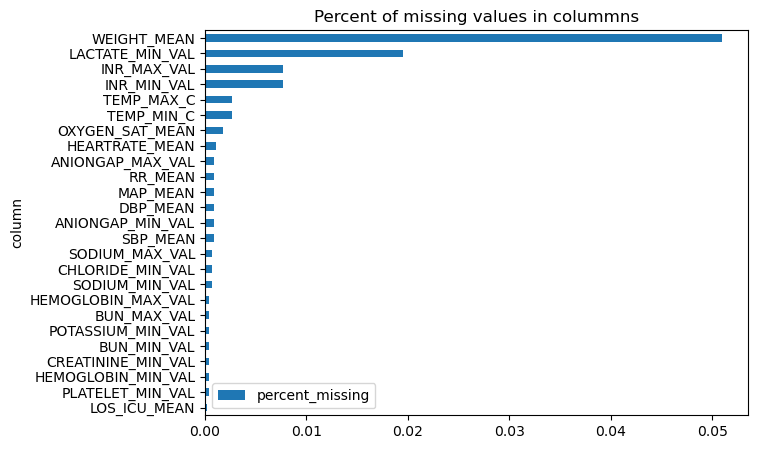

In [21]:
# visualize null values

def plot_missing_values(df):
    data = [(col, df[col].isnull().sum() / len(df)) 
            for col in df.columns if df[col].isnull().sum() > 0]
    col_names = ['column', 'percent_missing']
    missing_df = pd.DataFrame(data, columns=col_names).sort_values('percent_missing')
    pylab.rcParams['figure.figsize'] = (7, 5)
    missing_df.plot(kind='barh', x='column', y='percent_missing'); 
    plt.title('Percent of missing values in colummns');
plot_missing_values(df)

In [22]:
# replace null values in numeric columns

for col in df.select_dtypes(include=['number']):
    df[col].fillna(df[col].mean(), inplace=True)

In [23]:
# look for null values

df.isna().sum()

GENDER                0
ADMISSION_TYPE        0
ETHNICITY             0
AGE_AT_ADMISSION      0
LOS                   0
LOS_ICU_MEAN          0
WEIGHT_MEAN           0
HEARTRATE_MEAN        0
SBP_MEAN              0
DBP_MEAN              0
MAP_MEAN              0
RR_MEAN               0
TEMP_MIN_C            0
TEMP_MAX_C            0
OXYGEN_SAT_MEAN       0
DIABETES              0
ANIONGAP_MAX_VAL      0
BUN_MAX_VAL           0
HEMOGLOBIN_MAX_VAL    0
INR_MAX_VAL           0
SODIUM_MAX_VAL        0
ANIONGAP_MIN_VAL      0
BUN_MIN_VAL           0
CHLORIDE_MIN_VAL      0
CREATININE_MIN_VAL    0
HEMOGLOBIN_MIN_VAL    0
INR_MIN_VAL           0
LACTATE_MIN_VAL       0
PLATELET_MIN_VAL      0
POTASSIUM_MIN_VAL     0
SODIUM_MIN_VAL        0
MORTALITY             0
dtype: int64

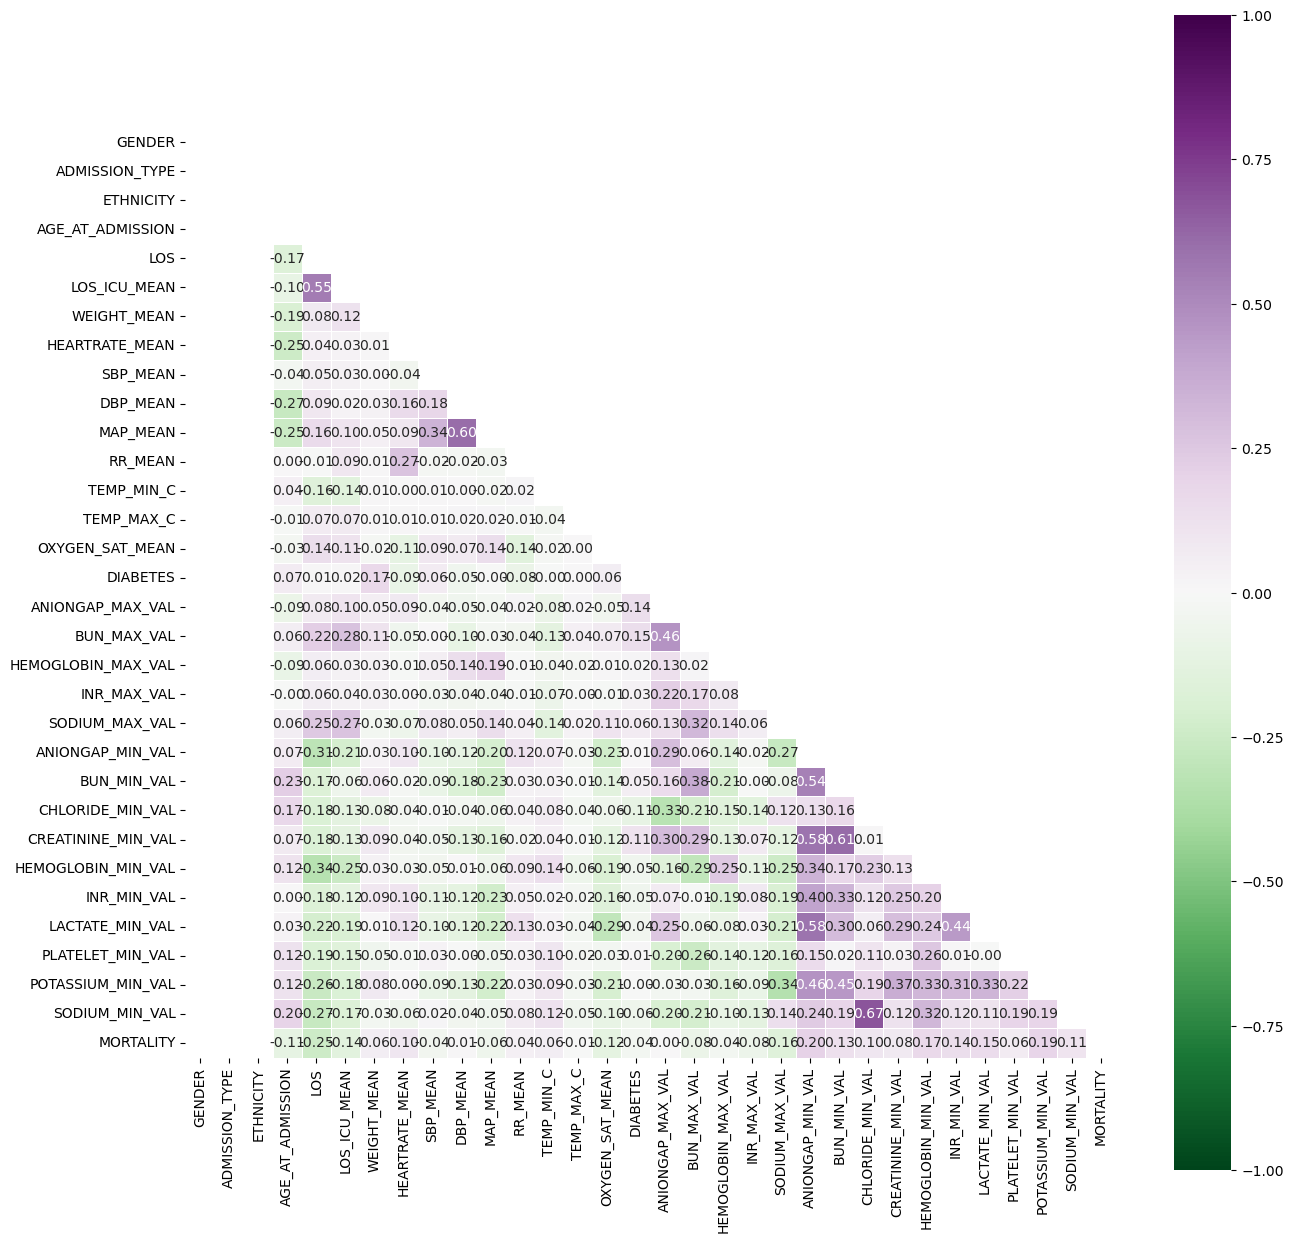

In [24]:
# create heatmap for numeric variables

num_df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
coco = num_df.corr()
tri_matrix = np.triu(coco)
plt.figure(figsize=(15, 15))
sns.heatmap(coco, square=True, linewidth=0.5, vmin=-1, vmax=1, cmap='PRGn_r', mask=tri_matrix, annot=True, fmt='.2f')
plt.show()

In [25]:
# create dummy variables for categorical columns

categorical_columns = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [26]:
# set target variable and split the data to two part (80% train set -20% test set)

X = df.drop(['MORTALITY'], axis=1)
y = df['MORTALITY']
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=42)

In [27]:
# handle outliers (Code form Joshua Cabal)

def mean_confidence_interval(data, confidence=0.95):
    """
    Calculate the mean and confidence interval for a list of numbers.
    """
    a = np.array(data)
    n = len(a)
    if n == 0:
        return np.nan, (np.nan, np.nan)
    mean = np.mean(a)
    se = stats.sem(a)
    if se == 0:
        return mean, (mean, mean)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, (mean - h, mean + h)

def get_stats(df, group_col='MORTALITY', confidence=0.95):
    """
    Analyze numerical features in the dataframe, aggregating by the specified group column.
    
    Parameters:
    - df: pandas DataFrame
    - group_col: column name to group by (binary: 0 or 1)
    - confidence: confidence level for intervals
    
    Returns:
    - result_df: pandas DataFrame with mean (CI) for each group and p-value
    """
    # Ensure the group column is binary
    if not set(df[group_col].unique()).issubset({0, 1}):
        raise ValueError(f"{group_col} must be binary (0 and 1).")
    
    # Select numerical columns excluding the group column
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col != group_col]
    
    result = []
    
    for col in numerical_cols:
        group0 = df[df[group_col] == 0][col].dropna()
        group1 = df[df[group_col] == 1][col].dropna()
        
        # Calculate means and confidence intervals
        mean0, ci0 = mean_confidence_interval(group0, confidence)
        mean1, ci1 = mean_confidence_interval(group1, confidence)
        
        # Perform t-test
        if len(group0) < 2 or len(group1) < 2:
            p_value = np.nan
        else:
            try:
                t_stat, p_value = stats.ttest_ind(group0, group1, equal_var=False, nan_policy='omit')
            except Exception:
                p_value = np.nan
        
        result.append({
            'Feature': col,
            f'Mean (0) [{int(confidence*100)}% CI]': f"{mean0:.4f} ({ci0[0]:.4f}, {ci0[1]:.4f})",
            f'Mean (1) [{int(confidence*100)}% CI]': f"{mean1:.4f} ({ci1[0]:.4f}, {ci1[1]:.4f})",
            'p-value': p_value
        })
    
    result_df = pd.DataFrame(result)
    return result_df

def preprocess_outliers(df, threshold=3):
    """
    Detects and caps outliers in non-binary numerical columns of the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - threshold (float): Number of standard deviations to define outliers (default is 3).
    
    Returns:
    - df_capped (pd.DataFrame): DataFrame with outliers capped.
    - summary_before (pd.DataFrame): Summary statistics before capping.
    - summary_after (pd.DataFrame): Summary statistics after capping.
    - capped_summary (pd.DataFrame): Count and percentage of capped values per column.
    - binary_numerical_cols (list): List of binary numerical columns.
    """
    # Identify numerical columns
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    # Detect binary numerical columns
    binary_numerical_cols = []
    for col in numerical_cols:
        unique_values = df[col].dropna().unique()
        if len(unique_values) == 2:
            binary_numerical_cols.append(col)
    
    # Separate non-binary numerical columns
    non_binary_numerical_cols = [col for col in numerical_cols if col not in binary_numerical_cols]
    
    # Calculate mean and std dev
    mean_values = df[non_binary_numerical_cols].mean()
    std_values = df[non_binary_numerical_cols].std()
    
    # Define bounds
    lower_bound = mean_values - threshold * std_values
    upper_bound = mean_values + threshold * std_values
    
    # Detect outliers
    outliers = pd.DataFrame(False, index=df.index, columns=non_binary_numerical_cols)
    for col in non_binary_numerical_cols:
        outliers[col] = (df[col] < lower_bound[col]) | (df[col] > upper_bound[col])
    
    # Summary statistics before capping
    summary_before = df[non_binary_numerical_cols].describe().transpose()
    summary_before = summary_before[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    summary_before.columns = ['Count', 'Mean', 'Std_Dev', 'Min', 'Q1', 'Median', 'Q3', 'Max']
    
    # Cap outliers
    df_capped = df.copy()
    for col in non_binary_numerical_cols:
        df_capped[col] = np.where(
            df_capped[col] < lower_bound[col],
            lower_bound[col],
            df_capped[col]
        )
        df_capped[col] = np.where(
            df_capped[col] > upper_bound[col],
            upper_bound[col],
            df_capped[col]
        )
    
    # Summary statistics after capping
    summary_after = df_capped[non_binary_numerical_cols].describe().transpose()
    summary_after = summary_after[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    summary_after.columns = ['Count', 'Mean_After', 'Std_Dev_After', 'Min_After', 'Q1_After', 'Median_After', 'Q3_After', 'Max_After']
    
    # Count of capped values per column
    capped_lower = (df[non_binary_numerical_cols] < lower_bound).sum()
    capped_upper = (df[non_binary_numerical_cols] > upper_bound).sum()
    total_capped = capped_lower + capped_upper
    total_entries = df[non_binary_numerical_cols].notna().sum()
    percent_capped = (total_capped / total_entries) * 100
    
    capped_summary = pd.DataFrame({
        'Capped_Lower': capped_lower,
        'Capped_Upper': capped_upper,
        'Total_Capped': total_capped,
        'Total_Entries': total_entries,
        'Percent_Capped': percent_capped.round(2)
    })
    
    # Overall totals
    overall_capped_lower = capped_lower.sum()
    overall_capped_upper = capped_upper.sum()
    overall_total_capped = overall_capped_lower + overall_capped_upper
    overall_total_entries = total_entries.sum()
    overall_percent_capped = (overall_total_capped / overall_total_entries) * 100
    
    overall_summary = pd.DataFrame({
        'Capped_Lower': [overall_capped_lower],
        'Capped_Upper': [overall_capped_upper],
        'Total_Capped': [overall_total_capped],
        'Total_Entries': [overall_total_entries],
        'Percent_Capped': [round(overall_percent_capped, 2)]
    }, index=['Overall'])
    
    # Append overall summary to capped_summary
    capped_summary = pd.concat([capped_summary, overall_summary])
    
    return df_capped, summary_before, summary_after, capped_summary, binary_numerical_cols

def compare_summary_stats(summary_before, summary_after, capped_summary):
    """
    Compares summary statistics before and after outlier handling.
    
    Parameters:
    - summary_before (pd.DataFrame): Summary statistics before handling outliers.
    - summary_after (pd.DataFrame): Summary statistics after handling outliers.
    - capped_summary (pd.DataFrame): Count and percentage of capped values per column.
    
    Returns:
    - comparison_table (pd.DataFrame): Table showing before, after, changes, and outlier counts.
    """
    # Initialize comparison DataFrame
    comparison_table = pd.DataFrame(index=summary_before.index)
    
    # Mean
    comparison_table['Mean Before'] = summary_before['Mean']
    comparison_table['Mean After'] = summary_after['Mean_After']
    comparison_table['Mean Change'] = comparison_table['Mean After'] - comparison_table['Mean Before']
    comparison_table['Mean % Change'] = (comparison_table['Mean Change'] / comparison_table['Mean Before']) * 100
    
    # Std Dev
    comparison_table['Std Dev Before'] = summary_before['Std_Dev']
    comparison_table['Std Dev After'] = summary_after['Std_Dev_After']
    comparison_table['Std Dev Change'] = comparison_table['Std Dev After'] - summary_before['Std_Dev']
    comparison_table['Std Dev % Change'] = (comparison_table['Std Dev Change'] / comparison_table['Std Dev Before']) * 100
    
    # Min
    comparison_table['Min Before'] = summary_before['Min']
    comparison_table['Min After'] = summary_after['Min_After']
    comparison_table['Min Change'] = comparison_table['Min After'] - summary_before['Min']
    comparison_table['Min % Change'] = (comparison_table['Min Change'] / summary_before['Min']) * 100
    
    # Max
    comparison_table['Max Before'] = summary_before['Max']
    comparison_table['Max After'] = summary_after['Max_After']
    comparison_table['Max Change'] = comparison_table['Max After'] - summary_before['Max']
    comparison_table['Max % Change'] = (comparison_table['Max Change'] / summary_before['Max']) * 100
    
    # Outlier Counts
    comparison_table['Capped_Lower'] = capped_summary['Capped_Lower']
    comparison_table['Capped_Upper'] = capped_summary['Capped_Upper']
    comparison_table['Total_Capped'] = capped_summary['Total_Capped']
    comparison_table['Percent_Capped'] = capped_summary['Percent_Capped']
    
    # Arrange columns for better readability
    comparison_table = comparison_table[[
        'Mean Before', 'Mean After', 'Mean Change', 'Mean % Change',
        'Std Dev Before', 'Std Dev After', 'Std Dev Change', 'Std Dev % Change',
        'Min Before', 'Min After', 'Min Change', 'Min % Change',
        'Max Before', 'Max After', 'Max Change', 'Max % Change',
        'Capped_Lower', 'Capped_Upper', 'Total_Capped', 'Percent_Capped'
    ]]
    
    return comparison_table

df_capped, summary_before, summary_after, capped_summary, binary_numerical_cols = preprocess_outliers(df, threshold=2)

comparison_table = compare_summary_stats(summary_before, summary_after, capped_summary)

comparison_table.to_csv('Outlier_Report.csv')
df_capped.to_csv('patient_df_capped.csv')

In [28]:
# use StandardScaler to standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Cross-Validation Accuracy Scores: [0.72557629 0.72228321 0.74204171 0.73984632 0.75082327]
Average Cross-Validation Accuracy: 0.74


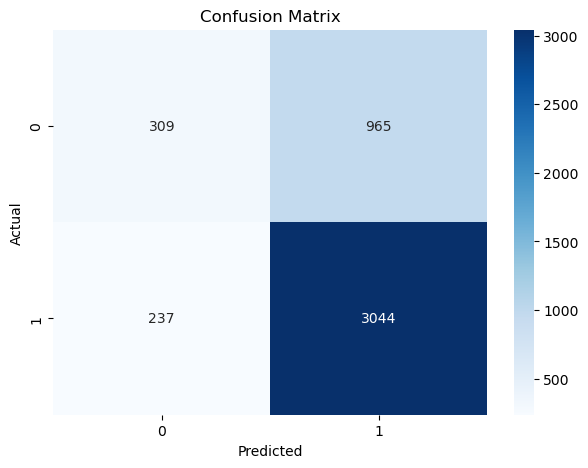

In [29]:
# create logestic regression model using kf
log_reg = LogisticRegression()
log_reg.fit(X_scaled, y)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(log_reg, X_scaled, y, cv=kf, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Average Cross-Validation Accuracy: {np.mean(cv_scores):.2f}')

y_pred = cross_val_predict(log_reg, X_scaled, y, cv=kf)
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

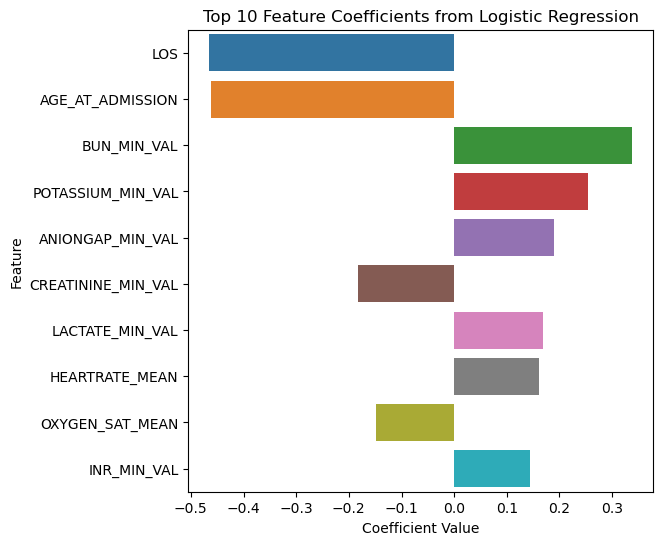

In [30]:
# plot top most impactful features from logestic regression

coefficients = log_reg.coef_[0]
coefficients_df = pd.DataFrame({'Feature':X.columns,'Coefficient':coefficients})
coefficients_df = coefficients_df.sort_values(by='Coefficient', key=abs, ascending=False)
top_features_df = coefficients_df.head(10)
plt.figure(figsize=(6, 6))
sns.barplot (x='Coefficient', y='Feature', data=top_features_df)
plt.title('Top 10 Feature Coefficients from Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

Random Forest Train Accuracy:  1.0
Random Forest Test Accuracy:  0.7574094401756312


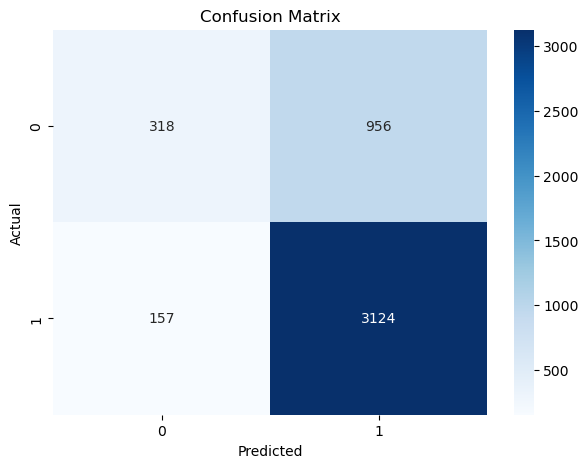

In [31]:
# create random forest model

random_forest = RandomForestClassifier (random_state=42, n_jobs=-1) 
random_forest.fit(X_train, y_train)
y_pred_train_rf = random_forest.predict(X_train)
y_pred_test_rf = random_forest.predict(X_test)
accuracy_train_rf = accuracy_score (y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score (y_test, y_pred_test_rf)
print('Random Forest Train Accuracy: ', accuracy_train_rf)
print('Random Forest Test Accuracy: ', accuracy_test_rf)

y_pred = cross_val_predict(random_forest, X, y, cv=kf)
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

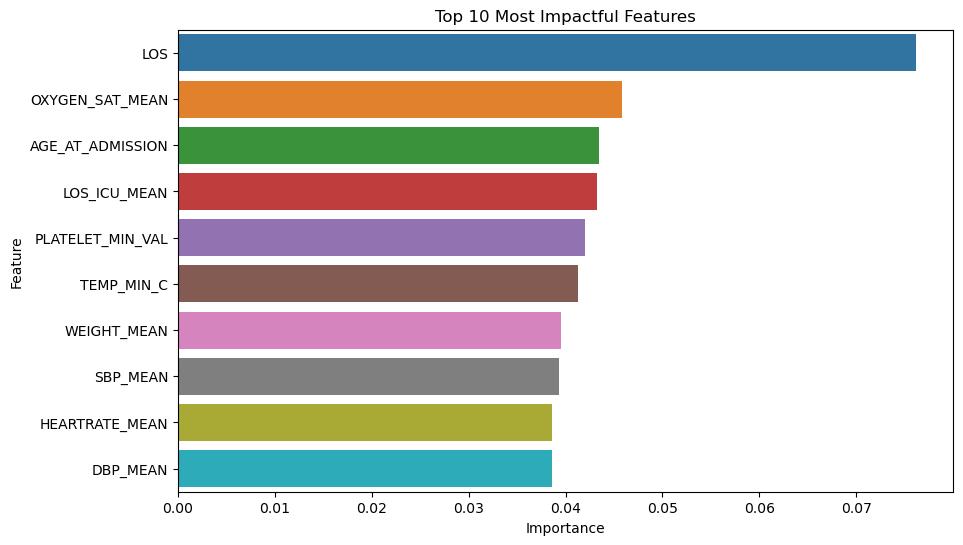

In [32]:
# plot random forest top ten features
importances = random_forest.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Most Impactful Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

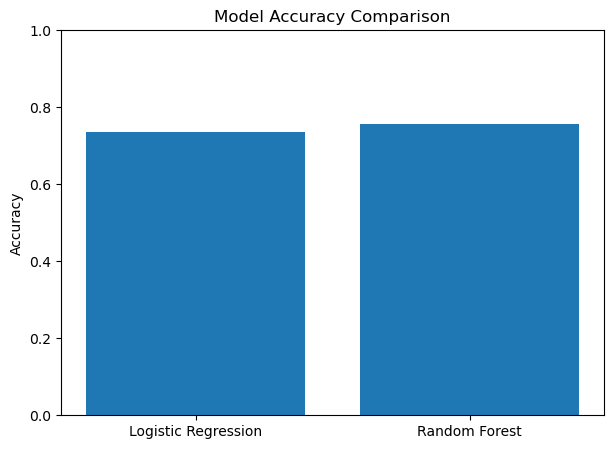

In [33]:
# comparing models accuracy

log_reg = LogisticRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_log_reg = cross_val_score(log_reg, X_scaled, y, cv=kf, scoring='accuracy')

random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest.fit(X_train, y_train)
accuracy_test_rf = accuracy_score(y_test, random_forest.predict(X_test))


avg_accuracy_log_reg = np.mean(cv_scores_log_reg)
models = ['Logistic Regression', 'Random Forest']
accuracies = [avg_accuracy_log_reg, accuracy_test_rf]

plt.bar(models, accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.show()

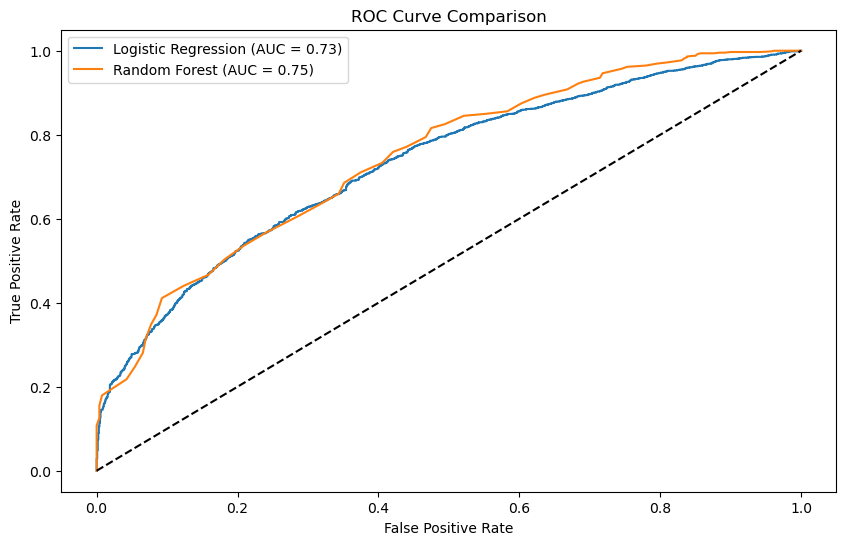

In [34]:
# comparing ROC curves

log_reg = LogisticRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_log_reg = cross_val_predict(log_reg, X_scaled, y, cv=kf, method='predict_proba')[:, 1]
auc_log_reg = roc_auc_score(y, y_pred_log_reg)

random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_pred_rf)

fpr_log_reg, tpr_log_reg, _ = roc_curve(y, y_pred_log_reg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

plt.figure(figsize=(10, 6))
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {auc_log_reg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()